In [ ]:
import torch
from transformers import AutoTokenizer

import shap
import pandas as pd
import matplotlib.pyplot as plt

from error_analysis_TRC import load_local_model
from TRC.utils_ea import create_token_dict, get_top_n

In [3]:
df_errati = pd.read_csv('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/tweet_errati.csv', index_col = 0)

In [5]:
ASSIGN_WEIGHT = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model_name = 'cardiffnlp/twitter-roberta-large-2022-154m'

model_path = '/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/saved-model/pytorch_model.bin'
config_path = '/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/saved-model/config.json'

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, normalization = True)
model = load_local_model(model_path, config_path, device, model_name)
model = model.to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-large-2022-154m were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
# come input prende una lista di tweet
def f(x):
    # x = [tweet_test[0]]
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128, truncation=True) for v in x]).to(device)
    # print('tv',tv.shape)
    attention_mask = (tv!=0).type(torch.int64).to(device)
    # print('atte',attention_mask.shape)
    model.eval()
    with torch.no_grad():
        outputs = model(tv, attention_mask, class_weight=None)
    # print(outputs)

    return outputs['logits']

In [8]:
explainer = shap.Explainer(f, masker = tokenizer)

FALSE POSITIVES

In [4]:
df_FP = df_errati[(df_errati['True label'] == 0 ) & (df_errati['Pred label'] == 1)]
df_FP = df_FP.reset_index()
df_FP.head()

,index,Tweet,True label,Pred label
0,1,Food poisoning in Mandeville HTTPURL,0,1
1,2,bel bev dabo food poison: HTTPURL via @USER,0,1
2,3,Douno why my mum trusts me cooking the dinner....,0,1
3,4,"{Me,My Gist and I} A Couple Died of Food Poiso...",0,1
4,5,"on top of all my pain, I feel like I have food...",0,1


In [8]:
tweet_FP = df_FP['Tweet'].values.tolist()

In [10]:
shap_values = explainer(tweet_FP)
shap_values.shape

Partition explainer: 60it [03:47,  4.06s/it]                        


(59, None, 2)

In [11]:
token_dict = create_token_dict(shap_values)
sorted = sorted(token_dict.items(), key = lambda x:x[1], reverse = True)
sorted_d = dict(sorted)


In [13]:
to_plot = get_top_n(20, sorted_d)

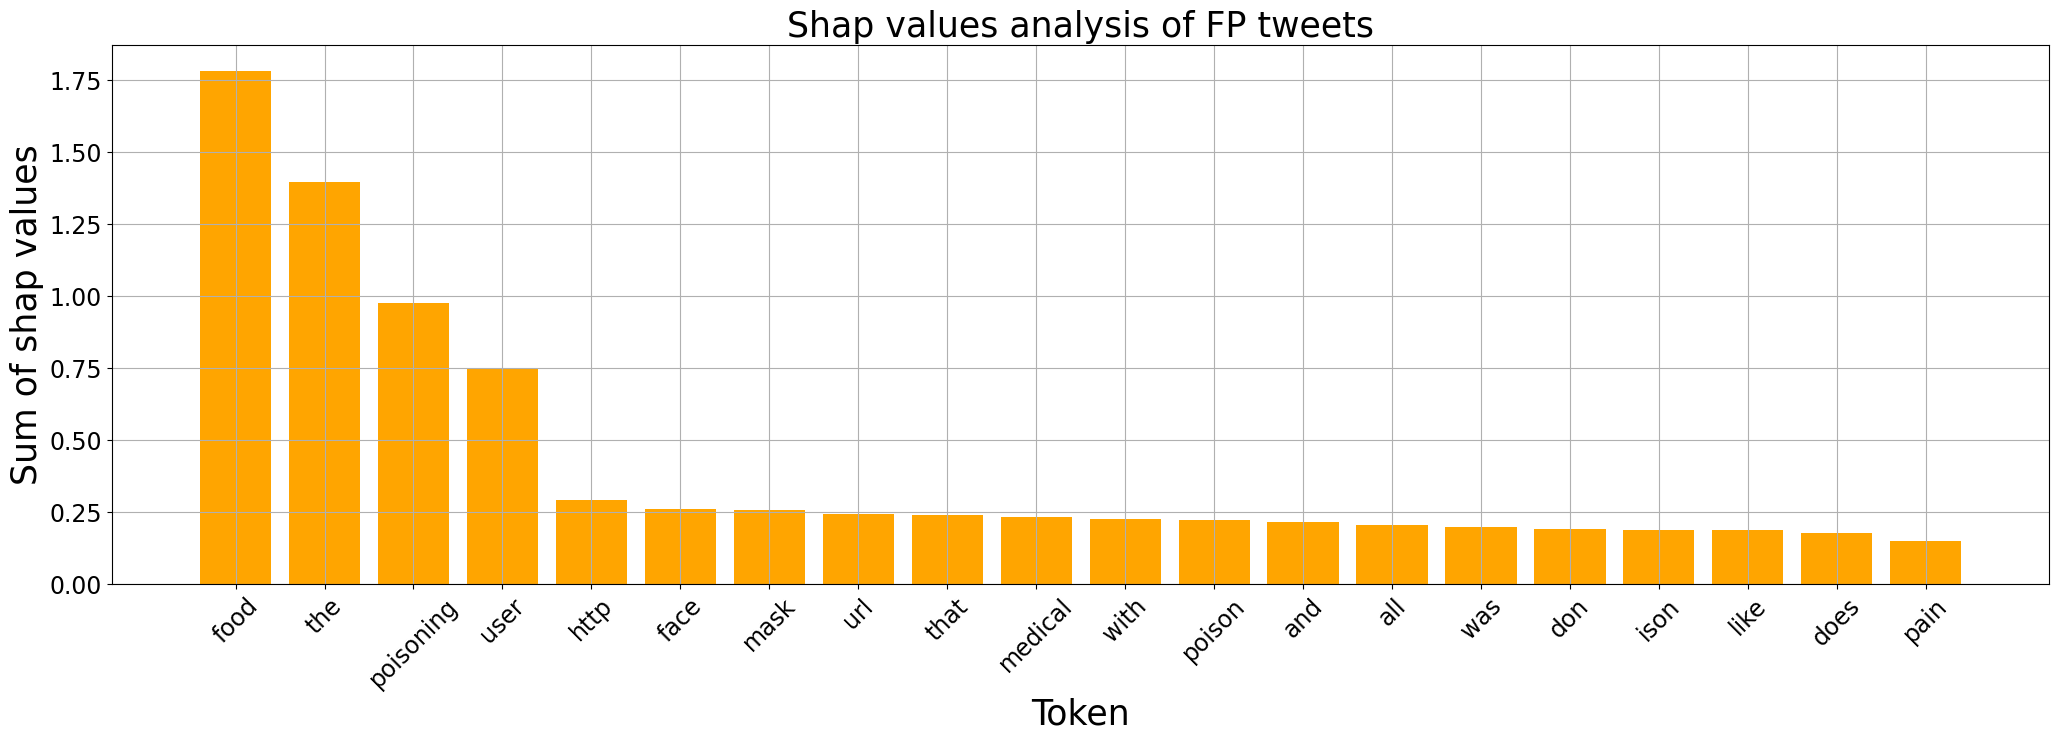

In [16]:
plt.figure(figsize=(25,7))
plt.bar(range(len(to_plot)), list(to_plot.values()), tick_label=list(to_plot.keys()), color = 'orange')
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis of FP tweets', fontsize = 25)
plt.xlabel('Token', fontsize = 25)
plt.ylabel('Sum of shap values', fontsize = 25)
plt.grid()
plt.savefig('shap_FP.png',bbox_inches='tight')
plt.show()

FALSE NEGATIVES

In [7]:
df_FN = df_errati[(df_errati['True label'] == 1 ) & (df_errati['Pred label'] == 0)]
df_FN = df_FN.reset_index()
df_FN.head()

,index,Tweet,True label,Pred label
0,0,"@USER @USER that's not good, do you know what ...",1,0
1,9,#SanJose #FoodPoisoning 93 #Shigella: Fever di...,1,0
2,19,@USER Where's the fun in that? I'd rather sele...,1,0
3,27,Like my 3rd time getting food poisoning this y...,1,0
4,31,getting food poisoning is a sick irony. sandwi...,1,0


In [8]:
tweet_FN = df_FN['Tweet'].values.tolist()

In [9]:
shap_values = explainer(tweet_FN)
shap_values.shape

Partition explainer: 9it [00:35,  5.07s/it]                       


(8, None, 2)

In [10]:
token_dict = create_token_dict(shap_values)
sorted = sorted(token_dict.items(), key = lambda x:x[1], reverse = True)
sorted_d = dict(sorted)

In [11]:
to_plot = get_top_n(20, sorted_d)

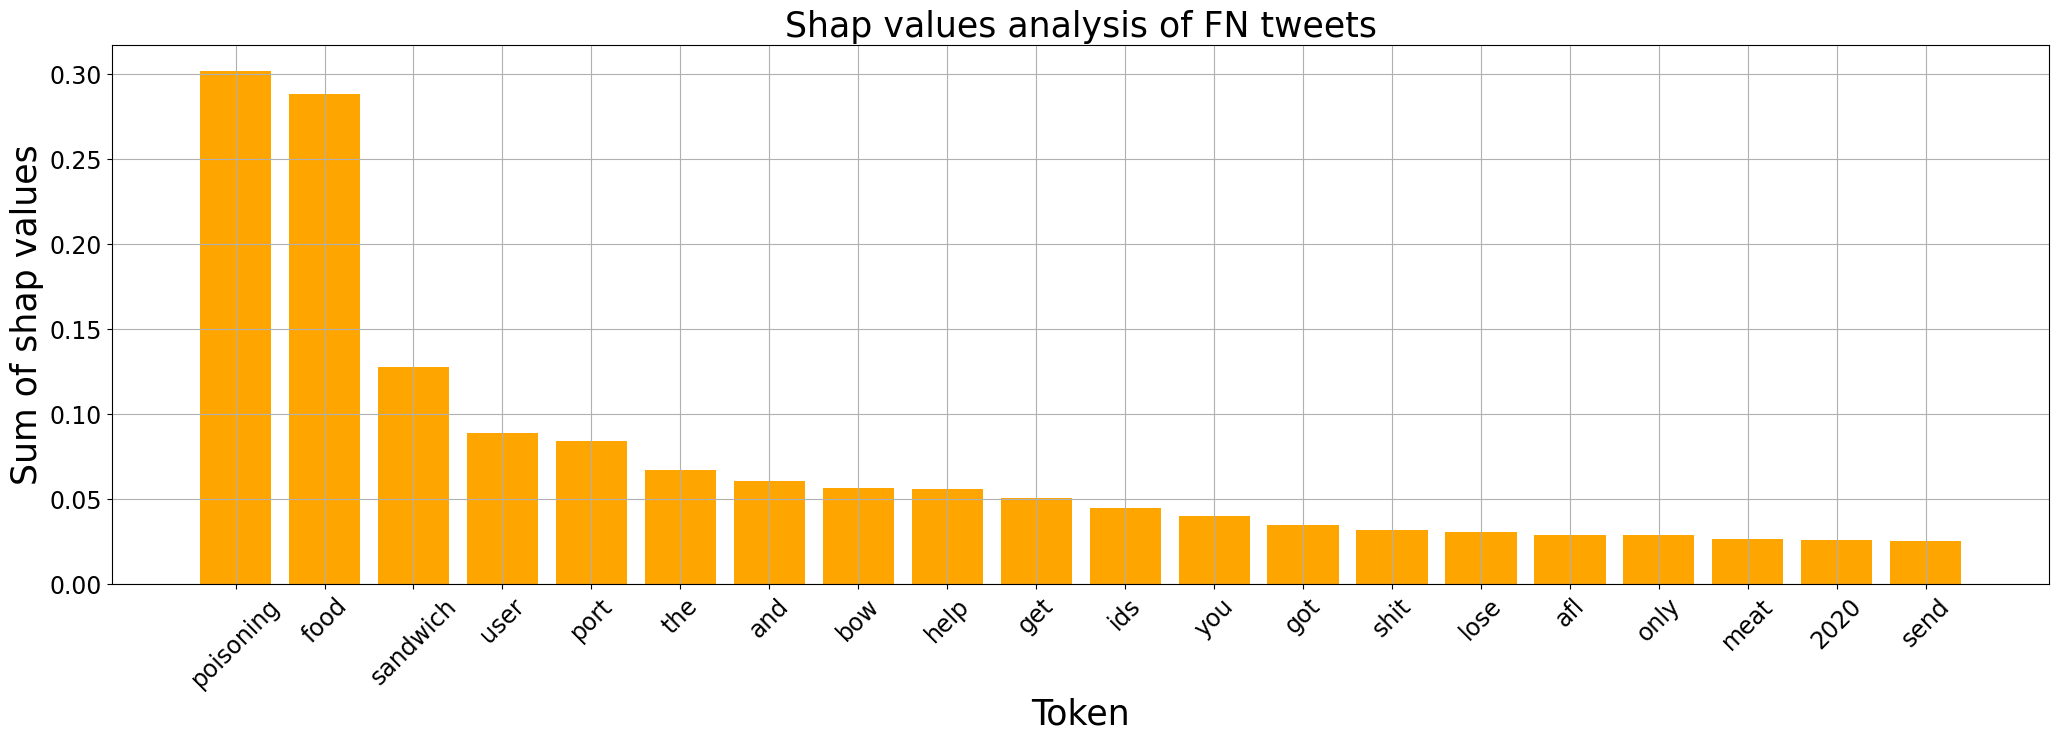

In [12]:
plt.figure(figsize=(25,7))
plt.bar(range(len(to_plot)), list(to_plot.values()), tick_label=list(to_plot.keys()), color = 'orange')
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis of FN tweets', fontsize = 25)
plt.xlabel('Token', fontsize = 25)
plt.ylabel('Sum of shap values', fontsize = 25)
plt.grid()
plt.savefig('shap_FN.png',bbox_inches='tight')
plt.show()

TRUE POSITIVES

In [9]:
df_corretti = pd.read_csv('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/tweet_corretti.csv', index_col=0)

In [10]:
df_TP = df_corretti[(df_corretti['True label'] == 1 ) & (df_corretti['Pred label'] == 1)]
df_TP = df_TP.reset_index()
df_TP.head()

,index,Tweet,True label,Pred label
0,0,@USER As much fun as I can. Woke up with food ...,1,1
1,1,I cant come into work today because I have foo...,1,1
2,2,I think it was that waffle house that did it.....,1,1
3,3,Today was rough. Think I had a touch of food p...,1,1
4,5,lmao RT @USER I've eaten off the streets in In...,1,1


In [11]:
tweet_TP = df_TP['Tweet'].values.tolist()

In [12]:
shap_values = explainer(tweet_TP)
shap_values.shape

Partition explainer: 130it [08:19,  3.90s/it]                         


(129, None, 2)

In [13]:
token_dict = create_token_dict(shap_values)
sorted = sorted(token_dict.items(), key = lambda x:x[1], reverse = True)
sorted_d = dict(sorted)

In [14]:
to_plot = get_top_n(20, sorted_d)

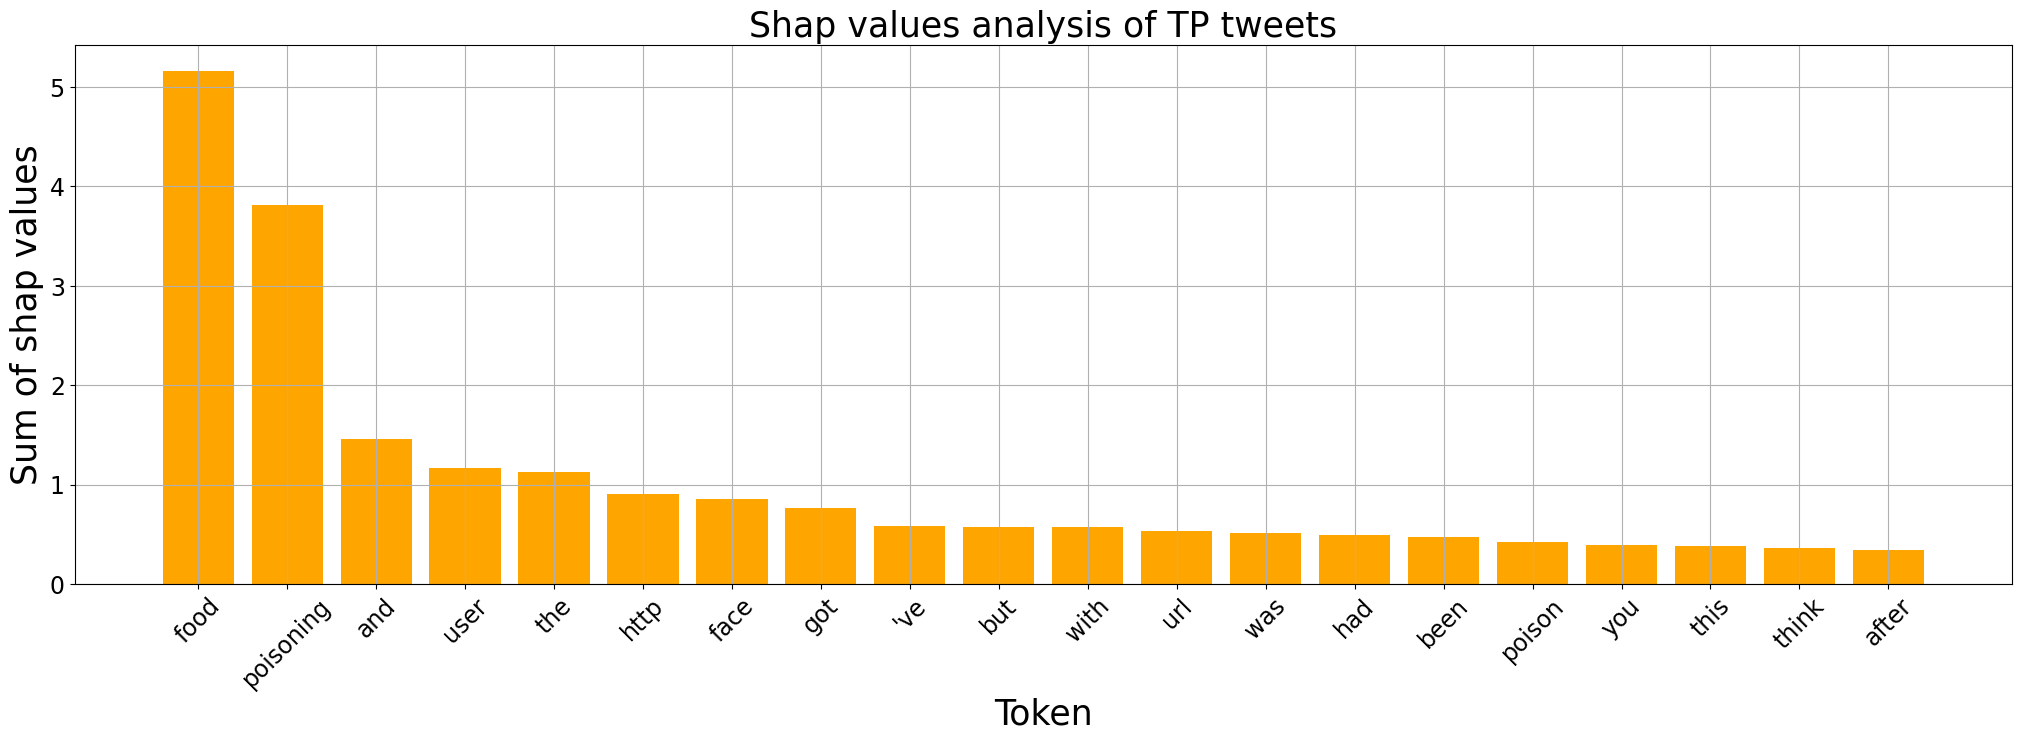

In [15]:
plt.figure(figsize=(25,7))
plt.bar(range(len(to_plot)), list(to_plot.values()), tick_label=list(to_plot.keys()), color = 'orange')
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis of TP tweets', fontsize = 25)
plt.xlabel('Token', fontsize = 25)
plt.ylabel('Sum of shap values', fontsize = 25)
plt.grid()
plt.savefig('shap_TP.png',bbox_inches='tight')
plt.show()

TRUE NEGATIVES

In [ ]:
df_TN = df_corretti[(df_corretti['True label'] == 0 ) & (df_corretti['Pred label'] == 0)]
df_TN = df_TN.reset_index()
df_TN.head()

In [ ]:
tweet_TN = df_TN['Tweet'].values.tolist()


In [ ]:
shap_values = explainer(tweet_TN)
shap_values.shape

In [ ]:
token_dict = create_token_dict(shap_values)
sorted = sorted(token_dict.items(), key = lambda x:x[1], reverse = True)
sorted_d = dict(sorted)

In [ ]:
to_plot = get_top_n(20, sorted_d)

In [ ]:
plt.figure(figsize=(25,7))
plt.bar(range(len(to_plot)), list(to_plot.values()), tick_label=list(to_plot.keys()), color = 'orange')
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis of TN tweets', fontsize = 25)
plt.xlabel('Token', fontsize = 25)
plt.ylabel('Sum of shap values', fontsize = 25)
plt.grid()
plt.savefig('shap_TN.png',bbox_inches='tight')
plt.show()